#### PTQ (Post-Training Quantization)

### PTQ Dynamic


#### Manual weight quantization AFTER training, without retraining, and without any calibration.

Weights: Quantized manually (INT8 → dequantized and copied into new model)

Activations: Not touched at all — still in FP32

Calibration: didn't perform

No retraining / QAT

This is a manual implementation of Dynamic Post-Training Quantization where only the weights are quantized and copied to a new model after training.

So this is Closest to:

Dynamic PTQ(manual implementation of Dynamic Post-Training Quantization)

✅ Weights quantized

❌ Activations untouched

❌ No calibration

❌ No QAT


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X, y = make_moons(n_samples=5000, noise=0.5, random_state=42)

In [ ]:
X

array([[ 0.64527536,  1.38251014],
       [ 0.14514823, -0.32157033],
       [ 0.11945131,  0.41631146],
       ...,
       [ 0.6360473 ,  0.66530771],
       [ 1.61542641, -0.24249711],
       [ 0.10599548,  1.0899585 ]])

In [ ]:
X.shape

(5000, 2)

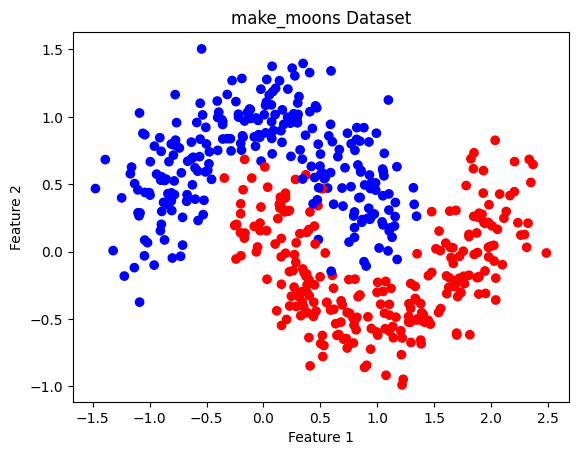

In [ ]:
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.title("make_moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
X = StandardScaler().fit_transform(X)  # normalize

In [ ]:
X = torch.tensor(X, dtype=torch.float32)

In [ ]:
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Original FP32 Model
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(2, 16)
#         self.fc2 = nn.Linear(16, 8)
#         self.fc3 = nn.Linear(8, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return torch.sigmoid(self.fc3(x))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BigMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return torch.sigmoid(self.fc7(x))

In [ ]:
model_fp32 = BigMLP()

Adam = Adaptive Moment Estimation

torch.optim.Adam() is what actually helps your neural network "learn" by updating its internal weights every step, using gradients and momentum.

model_fp32.parameters()

This means:

"Give the optimizer all the learnable parameters of the model —
which includes its weights and biases — so that the optimizer can update them during training."

lr=0.01

This is the learning rate, which controls:

"How fast the model updates its weights in each training step."

A higher learning rate → faster learning, but there's a risk of overshooting the optimal point.

A lower learning rate → slower and more stable learning, but it takes longer to converge.

In [ ]:
model_fp32.parameters()

<generator object Module.parameters at 0x7c080817a960>

In [ ]:
optimizer = torch.optim.Adam(model_fp32.parameters(), lr=0.01)

In [ ]:
loss_fn = nn.BCELoss()

In [ ]:
for epoch in range(2000):
    model_fp32.train()
    optimizer.zero_grad()
    out = model_fp32(X_train)

    loss = loss_fn(out, y_train)

    loss.backward()

    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 0.7018
Epoch 500 | Loss: 0.0097
Epoch 1000 | Loss: 0.0171
Epoch 1500 | Loss: 0.0010


This is thresholding the predictions:

If prediction > 0.5 → output = 1

Else → output = 0

Then converts the Boolean tensor into float (i.e., 1.0 or 0.0)

Basically:

preds = [0.91, 0.23, 0.66] → ❌ not usable

So we convert:

preds = [1.0, 0.0, 1.0]

Compares the predictions with the actual labels (y)

(preds == y) → gives a tensor of True/False → cast to float → 1.0 or 0.0

.mean() → average of all 1s and 0s = accuracy

.item() → convert final PyTorch scalar to a regular Python float (like 0.87)



In [ ]:
def accuracy(model, X, y):
    model.eval()
    with torch.no_grad():

        preds = model(X)

        preds = (preds > 0.5).float()

        return (preds == y).float().mean().item()

In [ ]:
print("\nFP32 Accuracy:", accuracy(model_fp32, X_test, y_test))


FP32 Accuracy: 0.9700000286102295


In [ ]:
from torch.quantization import quantize_dynamic

In [ ]:
# REAL DYNAMIC QUANTIZATION
model_int8 = quantize_dynamic(
    model_fp32,             # Original FP32 model
    {nn.Linear},            # Which layers to quantize
    dtype=torch.qint8       # Quantization dtype
)

In [ ]:
model_int8

BigMLP(
  (fc1): DynamicQuantizedLinear(in_features=2, out_features=128, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=128, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=64, out_features=64, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc4): DynamicQuantizedLinear(in_features=64, out_features=32, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc5): DynamicQuantizedLinear(in_features=32, out_features=16, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc6): DynamicQuantizedLinear(in_features=16, out_features=8, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc7): DynamicQuantizedLinear(in_features=8, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [ ]:
print("INT8 Quantized Accuracy:", accuracy(model_int8, X_test, y_test))

INT8 Quantized Accuracy: 0.9700000286102295


In [ ]:
model_fp32.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0327, -0.3705],
                      [-0.7268, -0.3635],
                      [-0.0281, -0.1552],
                      [ 0.0126,  0.9720],
                      [-0.4855, -0.0056],
                      [ 0.9236, -0.1011],
                      [-0.1847, -0.1562],
                      [ 0.9931,  0.3162],
                      [ 0.6974, -0.3151],
                      [ 0.3658, -0.2927],
                      [ 0.0530, -0.4962],
                      [ 0.7572, -0.2966],
                      [-0.2148, -0.2911],
                      [ 1.0573, -0.4012],
                      [-0.3342,  0.1330],
                      [ 0.3522, -0.0953],
                      [ 0.0115, -0.5237],
                      [ 0.3698,  0.5628],
                      [-0.1818,  0.7531],
                      [ 0.1182,  0.5494],
                      [-0.7885, -0.1293],
                      [ 0.5033, -0.5177],
                      [-0.3387, -0.3617],
      

In [ ]:
model_int8.state_dict()

OrderedDict([('fc1.scale', tensor(1.)),
             ('fc1.zero_point', tensor(0)),
             ('fc1._packed_params.dtype', torch.qint8),
             ('fc1._packed_params._packed_params',
              (tensor([[-0.0357, -0.3685],
                       [-0.7252, -0.3685],
                       [-0.0238, -0.1545],
                       [ 0.0119,  0.9748],
                       [-0.4874,  0.0000],
                       [ 0.9273, -0.1070],
                       [-0.1902, -0.1545],
                       [ 0.9986,  0.3210],
                       [ 0.7014, -0.3210],
                       [ 0.3685, -0.2972],
                       [ 0.0476, -0.4993],
                       [ 0.7608, -0.2972],
                       [-0.2140, -0.2853],
                       [ 1.0580, -0.4042],
                       [-0.3329,  0.1308],
                       [ 0.3566, -0.0951],
                       [ 0.0119, -0.5231],
                       [ 0.3685,  0.5587],
                       [-0.1783,  0

In [ ]:
import os
torch.save(model_fp32.state_dict(), "model_fp32.pt")
torch.save(model_int8.state_dict(), "model_dynamic_int8.pt")

In [ ]:
print("FP32 model size (MB):", os.path.getsize("model_fp32.pt") / 1e6)
print("INT8 model size (MB):", os.path.getsize("model_dynamic_int8.pt") / 1e6)

FP32 model size (MB): 0.066914
INT8 model size (MB): 0.025954


What quantize_dynamic() Actually Does:

1. Weights are quantized

All nn.Linear layer weights are converted from float32 → int8

Stored in compressed format

2. Activations are quantized at runtime ("on-the-fly")
During inference only

Input activations are not stored as int8, they are converted to int8 just before each layer

This is what makes it dynamic quantization

In [ ]:
# Quantization Logic (Manual INT8)
def quantize_tensor(t, num_bits=8):
    qmin = -2**(num_bits-1)
    qmax = 2**(num_bits-1) - 1
    min_val, max_val = t.min(), t.max()
    scale = (max_val - min_val) / float(qmax - qmin + 1e-8)
    zp = torch.round(-min_val / scale).to(torch.int32)
    q_t = torch.clamp(torch.round(t / scale) + zp, qmin, qmax).to(torch.int8)
    return q_t, scale, zp

In [ ]:
def dequantize_tensor(q_t, scale, zp):
    return (q_t.float() - zp) * scale

In [ ]:
# Apply Quantization to Weights Only
new_model = BigMLP()

In [ ]:
for name, param in new_model.named_parameters():
    print(name)
    print(param.shape)

fc1.weight
torch.Size([128, 2])
fc1.bias
torch.Size([128])
fc2.weight
torch.Size([64, 128])
fc2.bias
torch.Size([64])
fc3.weight
torch.Size([64, 64])
fc3.bias
torch.Size([64])
fc4.weight
torch.Size([32, 64])
fc4.bias
torch.Size([32])
fc5.weight
torch.Size([16, 32])
fc5.bias
torch.Size([16])
fc6.weight
torch.Size([8, 16])
fc6.bias
torch.Size([8])
fc7.weight
torch.Size([1, 8])
fc7.bias
torch.Size([1])


In [ ]:
with torch.no_grad():
    for (name_fp, param_fp), (name_q, param_q) in zip(model_fp32.named_parameters(), new_model.named_parameters()):

        q_param, scale, zp = quantize_tensor(param_fp.data)

        dq_param = dequantize_tensor(q_param, scale, zp)

        param_q.data.copy_(dq_param)

In [ ]:
print("\n INT8 Accuracy:", accuracy(new_model, X_test, y_test))


 INT8 Accuracy: 0.4300000071525574


Compressing FP32 tensors into int8 format to save memory & improve speed

Convert a floating point tensor t (e.g., model weights) into INT8 range:
from 32-bit floats → 8-bit integers

also return the scale and zero point, so you can later reverse it (dequantize)

| Step                                | Purpose                            |
| ----------------------------------- | ---------------------------------- |
| `min/max`                           | Find range of your data            |
| `scale`                             | How much 1 INT8 step = in float    |
| `zp`                                | Align 0.0 to the right INT8 number |
| `quantized = round(t / scale) + zp` | Main formula                       |
| `clamp`                             | Keep values between -128 and 127   |


model_int8 is NOT truly INT8 model

It's still FP32 model —

But the weights were passed through a quant–dequant cycle to simulate the loss.

This is why we say:

This is not real quantized inference — it's quantization simulation.

Purpose of this block:

Take the trained model (model_fp32),

Quantize its weights using quantize_tensor()

Then dequantize them back to FP32

And load them into a new model (model_int8) for testing

It's like saying:

"Compress the weights → decompress them → test how much damage happened"

Basically: simulating quantization impact on your model — without actual INT8 inference.

Inference is happening at FP32, since you dequantized the weights.

So you are not testing real quantized inference.

This is not real quantized inference

→ It is a simulation to understand quantization error

→ i.e., How much precision loss happens when compressing weights

Let's take a simple real-life analogy:

You have:

- A weight: w = 1.23456789 (high precision)

- You quantize (compress): w_q = 123 (INT8)

- Then dequantize (decompress): w_deq = 1.23 (approximate value)

Now compare:

- Original: 1.23456789

- After round trip (quant-dequant): 1.23

You see the "damage" = the difference

# PTQ Static

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

X = StandardScaler().fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Original FP32 Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

model_fp32 = MLP()

optimizer = torch.optim.Adam(model_fp32.parameters(), lr=0.01)

loss_fn = nn.BCELoss()

for epoch in range(2000):
    model_fp32.train()
    optimizer.zero_grad()
    out = model_fp32(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

  # Accuracy
def accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X)
        preds = (preds > 0.5).float()
        return (preds == y).float().mean().item()

print("\nFP32 Accuracy:", accuracy(model_fp32, X_test, y_test))


FP32 Accuracy: 0.9599999785423279


In [ ]:
def quantize_tensor(t, num_bits=8):
    qmin = -2**(num_bits - 1) #-128
    qmax = 2**(num_bits - 1) - 1 #127
    min_val, max_val = t.min(), t.max()
    scale = (max_val - min_val) / (qmax - qmin + 1e-8)
    zp = torch.round(-min_val / scale).to(torch.int32)
    q_t = torch.clamp(torch.round(t / scale) + zp, qmin, qmax).to(torch.int8)
    return q_t, scale, zp

def dequantize_tensor(q_t, scale, zp):
    return (q_t.float() - zp) * scale

| Term                   |  Meaning                                           |
| ------------------------- | ---------------------------------------------------- |
| `hook`                    | A function that "hooks into" model layers            |
| `forward_hook`            | Runs when the layer does a forward pass              |
| `register_forward_hook()` | Registers the hook on the layer                      |
| Used For                  | Getting layer activations, gradients, debugging, etc |


Purpose → Collect the min/max activation range of each nn.Linear layer (for quantization calibration).

Hook function → During forward pass, captures each layer’s output and stores its min() and max().

Registration → Hooks are attached only to nn.Linear layers using register_forward_hook.

Forward pass → Calibration samples (X_sample) are passed through the model → hooks record the values.

Cleanup → Hooks are removed afterward to avoid memory leaks.

Return → Returns a dictionary {layer_name: (min, max)} with activation ranges.

Intuition → These min/max values are later used to compute scale and zero-point for quantization.

In [ ]:
# Calibration: Get activation ranges
def get_activation_min_max(model, X_sample):
    act_ranges = {}
    hooks = []

    def register_hook(name):
        def hook_fn(module, input, output):
            act_min = output.min().item()
            act_max = output.max().item()
            act_ranges[name] = (act_min, act_max)
        return hook_fn

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            hooks.append(module.register_forward_hook(register_hook(name)))

    with torch.no_grad():
        model.eval()
        model(X_sample)

    for h in hooks:
        h.remove()

    return act_ranges

In [ ]:
X_calib = X_train[:100]

In [ ]:
act_ranges = get_activation_min_max(model_fp32, X_calib)

In [ ]:
act_ranges

{'fc1': (-8.62429428100586, 6.317246437072754),
 'fc2': (-18.306520462036133, 18.562524795532227),
 'fc3': (-100.20124816894531, 83.4000473022461)}

What’s happening?
You loop through each weight in the FP32 model.

Quantize it to INT8 with quantize_tensor()

Immediately dequantize back to FP32 with dequantize_tensor()
(Because we’re not doing true INT8 inference — just simulating quantization loss.)

Then copy this dequantized value into the new model’s weights.

This tells us: "What would happen to accuracy if we had compressed the weights?"

In [ ]:
class QuantizedMLP(nn.Module):
    def __init__(self, fp_model, act_ranges):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

        # Quantize weights
        with torch.no_grad():
            for (name_fp, param_fp), (name_q, param_q) in zip(fp_model.named_parameters(), self.named_parameters()):
                q_param, scale, zp = quantize_tensor(param_fp.data)
                dq_param = dequantize_tensor(q_param, scale, zp)
                param_q.data.copy_(dq_param)

        # Store activation scales
        self.act_scales = {}
        for name, (amin, amax) in act_ranges.items():
            scale = (amax - amin) / 255.0
            zp = round(-amin / scale) if scale > 0 else 0
            self.act_scales[name] = (scale, zp)

    def quant_act(self, x, layer_name):
        scale, zp = self.act_scales[layer_name]
        q_x = torch.clamp(torch.round(x / scale) + zp, 0, 255).to(torch.uint8)
        dq_x = (q_x.float() - zp) * scale
        return dq_x

    def forward(self, x):
        x = F.relu(self.quant_act(self.fc1(x), 'fc1'))
        x = F.relu(self.quant_act(self.fc2(x), 'fc2'))
        return torch.sigmoid(self.fc3(x))

In [ ]:
model_static_ptq = QuantizedMLP(model_fp32, act_ranges)
print("STATIC PTQ Accuracy:", accuracy(model_static_ptq, X_test, y_test))

STATIC PTQ Accuracy: 0.4300000071525574


Why are we NOT doing real INT8 inference in this code?
Because we're doing manual quantization using PyTorch (pure Python code), and:

PyTorch’s default layers (like nn.Linear) do NOT support actual INT8 operations on CPU/GPU unless we use special quantized modules.

You're doing:

✅ Quantization → simulate converting to INT8

❌ BUT then Dequantization → you bring it back to FP32

✅ FP32 Layer runs → because your model (nn.Linear) expects float tensors

When does real INT8 inference happen?

Only when you use:

from torch.quantization import quantize_dynamic

torch.quantization.prepare() + convert()

These internally replace layers like nn.Linear with quantized versions like:

torch.nn.quantized.Linear


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.quantization
# from sklearn.datasets import make_moons
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Step 1: Prepare Dataset
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X = StandardScaler().fit_transform(X)

# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 2: Define Quantizable MLP
# class QuantMLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # MUST use QuantStub and DeQuantStub for static quantization
#         self.quant = torch.quantization.QuantStub()
#         self.fc1 = nn.Linear(2, 16)
#         self.fc2 = nn.Linear(16, 8)
#         self.fc3 = nn.Linear(8, 1)
#         self.dequant = torch.quantization.DeQuantStub()

#     def forward(self, x):
#         x = self.quant(x)                      # Quantize input
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         x = self.dequant(x)                    # Dequantize output
#         return x

# # Step 3: Train FP32 Model
# model_fp32 = QuantMLP()
# optimizer = torch.optim.Adam(model_fp32.parameters(), lr=0.01)
# loss_fn = nn.BCELoss()

# for epoch in range(2000):
#     model_fp32.train()
#     optimizer.zero_grad()
#     out = model_fp32(X_train)
#     loss = loss_fn(out, y_train)
#     loss.backward()
#     optimizer.step()

# # Step 4: Define Accuracy Function
# def accuracy(model, X, y):
#     model.eval()
#     with torch.no_grad():
#         preds = model(X)
#         preds = (preds > 0.5).float()
#         return (preds == y).float().mean().item()

# print("FP32 Accuracy:", accuracy(model_fp32, X_test, y_test))

# # Step 5: Static PTQ (REAL)
# model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')  # Backend config (CPU)
# torch.quantization.prepare(model_fp32, inplace=True)  # Insert observers

# # Calibration Step (Run some real data through model)
# with torch.no_grad():
#     model_fp32(X_train)

# torch.quantization.convert(model_fp32, inplace=True)  # Convert to INT8

# print("INT8 Accuracy:", accuracy(model_fp32, X_test, y_test))

# # Optional: Print model to verify quantized layers
# print(model_fp32)


# QAT (Quantization Aware Training)

torch, nn, F: PyTorch essentials for model, layers, and functions.

make_moons: Generates 2D binary classification data (two semicircles) – easy to visualize and train.

train_test_split: Splits dataset into train and test.

StandardScaler: Normalizes inputs to mean=0 and std=1.

torch.quantization: Module that gives you all the tools for quantization (like QAT, PTQ, etc).



By default, PyTorch runs models on the CPU using FP32 (32-bit floating point) precision.

For real INT8 inference, special hardware backends are required — such as x86 (with AVX2/AVX512), FBGEMM, or QNNPACK.

But when you're manually applying quantization and dequantization (i.e., using fake quantization), you're essentially just simulating it.

You're asking the question:

“If this model were quantized, how different would its output be?”

So simulation here means:

"We're not actually running on real quantized hardware, but we can still observe how quantization would affect the model's outputs in software."

Original FP32 Tensor:

tensor([ 0.1200, -0.8500,  0.5600, -0.3300,  0.9100])

After Quantization to INT8:

tensor([127,   0, 127,  75, 127], dtype=torch.int8)

After Dequantization:

tensor([ 0.0276, -0.8489,  0.0276, -0.3313,  0.0276])

absolute Error (FP32 − Dequantized):

tensor([0.0924, 0.0011, 0.5324, 0.0013, 0.8824])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch.quantization

# Dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Accuracy Function
def accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X)
        preds = (preds > 0.5).float()
        return (preds == y).float().mean().item()

# QAT-compatible Model
class QATMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.dequant(x)
        return x

In [ ]:
# Initialize model
model = QATMLP()

In [ ]:
torch.quantization.get_default_qat_qconfig('fbgemm')

QConfig(activation=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, quant_min=0, quant_max=255, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.fake_quantize.FusedMovingAvgObsFakeQuantize'>, observer=<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [ ]:
# Define quantization config
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

In [ ]:
# Prepare QAT model (insert fake quant nodes)
torch.quantization.prepare_qat(model, inplace=True)

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


QATMLP(
  (quant): QuantStub(
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (fc1): Linear(
    in_features=2, out_features=16, bias=True
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (activation_post_process): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1]), observe

In [ ]:
# Optimizer + Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

In [ ]:
# Train with Fake Quantization
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 0.6883
Epoch 500 | Loss: 0.1722
Epoch 1000 | Loss: 0.0628
Epoch 1500 | Loss: 0.0402


In [ ]:
print("Accuracy before convert():", accuracy(model, X_test, y_test))

Accuracy before convert(): 0.9700000286102295


In [ ]:
# Convert to real INT8 model
model_int8 = torch.quantization.convert(model.eval(), inplace=False)

In [ ]:
print("QAT INT8 Accuracy:", accuracy(model_int8, X_test, y_test))

QAT INT8 Accuracy: 0.9800000190734863


 In real INT8 inference, your model should directly use:

tensor([127, 0, 127, 75, 127], dtype=torch.int8)

Here's the truth:

These int8 values are meant to be directly consumed by quantized operators (like qlinear, qconv, etc.)

hese operators know how to compute using:

INT8 weights

INT8 activations

plus saved scale and zero_point

But why do we simulate with dequantization then?
Because:

In pure PyTorch (without enabling real quantized backends like FBGEMM, QNNPACK), we can't execute real int8 ops.

So we do:

Quantize → Dequantize → FP32 inference
Just to test the accuracy drop before switching to real INT8 path.

REAL INT8 inference happens in:

PyTorch with torch.quantization.convert() + qengine

ONNX Runtime

TensorRT

TFLite

Or mobile deployment